# Symulacja 2D PDE (Standalone - Modified Paths)

Ten notebook jest samodzielną wersją `sim_01_pde.ipynb`. Wszystkie zależności z katalogu `src` zostały zintegrowane w komórkach poniżej.

- Zmieniono ścieżkę zapisu na `../figures/sim_01`.
- Ustawiono kolor tła na `#252629`.
- Dodano konfigurację `PROJECT_ROOT`.


In [1]:
import sys
import os
from pathlib import Path
from dataclasses import dataclass, field
from typing import Literal, Tuple

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import imageio.v2 as imageio

print("Biblioteki załadowane pomyślnie.")

Biblioteki załadowane pomyślnie.


In [2]:
# ==========================================
# KOD ZAIMPORTOWANY Z: src/methods/viz_style.py
# ==========================================

COLORS = {
    'pde': '#004488',      # Ciemny niebieski (Explicit)
    'rk45': '#BB5566',     # Magenta (Solver RK45)
    'dose': '#BBBBBB',     # Szary (Dawka)
    'truth': 'black'
}

def set_style():
    """Ustawia profesjonalny styl wykresów do publikacji/prezentacji."""
    # Fallback jeśli brak stylu seaborn
    try:
        plt.style.use('seaborn-v0_8-paper')
    except:
        plt.style.use('fast')
    
    mpl.rcParams.update({
        'font.family': 'sans-serif',
        'font.size': 12,
        'axes.titlesize': 14,
        'axes.labelsize': 13,
        'legend.fontsize': 11,
        'lines.linewidth': 2.5,
        'grid.alpha': 0.3,
        'figure.figsize': (10, 6),
        'figure.dpi': 150,
        'image.cmap': 'magma' 
    })

In [3]:
# ==========================================
# KOD ZAIMPORTOWANY Z: src/models/pde.py (Część 2D)
# ==========================================

# --- KONFIGURACJA I PARAMETRY ---

@dataclass
class Grid:
    L_mm: float = 50.0
    N: int = 100
    x: np.ndarray = field(init=False, repr=False)
    y: np.ndarray = field(init=False, repr=False)
    dx: float = field(init=False)

    def __post_init__(self) -> None:
        self.dx = self.L_mm / self.N
        self.x = np.linspace(0.0, self.L_mm, self.N)
        self.y = np.linspace(0.0, self.L_mm, self.N)

@dataclass
class TumorKinetics:
    D_mm2_per_day: float = 0.137     
    rho_per_day: float   = 0.0274    
    K: float = 1.0                   

@dataclass
class Radiobiology:
    mode: Literal["pde_kill", "lq_pulses"] = "lq_pulses"
    beta_rt_per_Gy: float = 0.06
    alpha: float = 0.06              
    beta: float  = 0.006             
    OER_max: float = 3.0
    K_m_mmHg: float = 3.0

@dataclass
class DoseSchedule:
    start_day: float = 10.0
    n_fractions: int = 30
    d_per_frac_Gy: float = 2.0
    frac_duration_day: float = 0.004  # ~6 min

@dataclass
class Beam:
    profile: Literal["uniform", "gaussian"] = "uniform"
    sigma_mm: float = 10.0

@dataclass
class SimConfig:
    T_days: float = 60.0
    dt_day: float = 0.05
    grid: Grid = field(default_factory=Grid)
    tumor: TumorKinetics = field(default_factory=TumorKinetics)
    rtd: Radiobiology = field(default_factory=Radiobiology)
    schedule: DoseSchedule = field(default_factory=DoseSchedule)
    beam: Beam = field(default_factory=Beam)

    def stability_ok(self) -> bool:
        dx = self.grid.dx
        D = self.tumor.D_mm2_per_day
        return self.dt_day <= (dx*dx) / (4.0*D)

# --- NUMERYKA I FIZYKA ---

def laplacian_neumann(u: np.ndarray, dx: float) -> np.ndarray:
    """Oblicza Laplacian 2D z warunkami brzegowymi Neumanna (odbicie)."""
    up = np.pad(u, 1, mode="edge")
    return (up[2:,1:-1] + up[:-2,1:-1] + up[1:-1,2:] + up[1:-1,:-2] - 4*up[1:-1,1:-1]) / (dx*dx)

def init_tumor_gaussian(N: int, L_mm: float, peak: float = 0.1, sigma_mm: float = 5.0) -> np.ndarray:
    x = np.linspace(0.0, L_mm, N)
    X, Y = np.meshgrid(x, x, indexing="ij")
    return peak * np.exp(-((X - L_mm/2)**2 + (Y - L_mm/2)**2) / (2*sigma_mm**2))

def radial_pO2(N: int, p_center: float = 1.0, p_edge: float = 30.0) -> np.ndarray:
    """Fantazmat hipoksji: niedotleniony środek, natlenione brzegi."""
    yy, xx = np.meshgrid(np.linspace(-1, 1, N), np.linspace(-1, 1, N), indexing="ij")
    r = np.clip(np.sqrt(xx*xx + yy*yy), 0.0, 1.0)
    return p_center + (p_edge - p_center) * r

def omf_from_pO2(pO2: np.ndarray, OER_max: float = 3.0, K_m_mmHg: float = 3.0) -> np.ndarray:
    """Oxygen Modification Factor"""
    return (1.0 + (OER_max - 1.0) * (pO2 / (pO2 + K_m_mmHg))) / OER_max

def weekday_fractions(start_day: float, n: int) -> np.ndarray:
    """Harmonogram: Pn-Pt (przerwa weekendowa)."""
    times = []
    d = start_day
    for i in range(n):
        times.append(d)
        d += 1.0
        if (i+1) % 5 == 0:
            d += 2.0
    return np.array(times)

def beam_profile(N: int, L_mm: float, kind: str, sigma_mm: float) -> np.ndarray:
    if kind == "uniform":
        return np.ones((N, N))
    x = np.linspace(0.0, L_mm, N)
    X, Y = np.meshgrid(x, x, indexing="ij")
    r2 = (X - L_mm/2)**2 + (Y - L_mm/2)**2
    g = np.exp(-r2 / (2*sigma_mm**2))
    return g / g.max()

# --- GŁÓWNA PĘTLA SYMULACJI ---

@dataclass
class SimOutput:
    times: np.ndarray
    u_final: np.ndarray
    total_mass: np.ndarray
    dose_rate_series: np.ndarray
    beam: np.ndarray

def run_2d_simulation(cfg: SimConfig, save_hook=None) -> SimOutput:
    g = cfg.grid
    kin = cfg.tumor
    rb = cfg.rtd
    sch = cfg.schedule
    b = cfg.beam

    # Walidacja stabilności
    if not cfg.stability_ok():
        print(f"Ostrzeżenie: dt={cfg.dt_day} może być niestabilne!")

    # Inicjalizacja pól
    u = init_tumor_gaussian(g.N, g.L_mm)
    pO2 = radial_pO2(g.N)
    H = omf_from_pO2(pO2, rb.OER_max, rb.K_m_mmHg)
    beam = beam_profile(g.N, g.L_mm, b.profile, b.sigma_mm)

    dt = cfg.dt_day
    times = np.arange(0.0, cfg.T_days + 1e-12, dt)
    total_mass = np.zeros_like(times)
    dose_rate_series = np.zeros_like(times)

    # Harmonogram
    fr_t = weekday_fractions(sch.start_day, sch.n_fractions)
    fr_end = fr_t + sch.frac_duration_day
    dose_rate_val = sch.d_per_frac_Gy / sch.frac_duration_day

    # Parametry LQ
    alpha_eff = rb.alpha * H
    beta_eff  = rb.beta * (H**2)

    def in_window(t: float) -> bool:
        return np.any((t >= fr_t) & (t < fr_end))

    max_u_init = np.max(u)

    # Pętla czasowa
    for k, t in enumerate(times):
        # 1. Dyfuzja (PDE)
        Lu = laplacian_neumann(u, g.dx)
        growth = kin.rho_per_day * u * (1.0 - u/kin.K)
        du = kin.D_mm2_per_day * Lu + growth

        # 2. Radioterapia (Continuous PDE kill lub LQ pulses)
        current_dose_rate = 0.0
        if in_window(t):
            current_dose_rate = dose_rate_val
        
        dose_rate_series[k] = current_dose_rate

        if rb.mode == "pde_kill" and current_dose_rate > 0:
            kill = rb.beta_rt_per_Gy * (current_dose_rate * beam) * H * u
            du -= kill

        # Euler step
        u = np.clip(u + dt*du, 0.0, kin.K)

        # 3. Model LQ (dyskretny skok przeżywalności na koniec frakcji)
        if rb.mode == "lq_pulses":
            # Sprawdzamy czy właśnie skończyła się frakcja
            for te in fr_end:
                if (t - dt) < te <= t + 1e-12:
                    d_map = sch.d_per_frac_Gy * beam
                    S = np.exp(-(alpha_eff*d_map + beta_eff*d_map**2))
                    u *= S
                    break

        total_mass[k] = u.sum()

        if save_hook is not None:
            save_hook(k, t, u, times[:k+1], total_mass[:k+1], dose_rate_series[:k+1], max_u_init)

    return SimOutput(times, u, total_mass, dose_rate_series, beam)

In [4]:
# =============================
# USTAWIENIA UŻYTKOWNIKA (ZMODYFIKOWANE)
# =============================

OUTPUT_DIR = Path('../figures/sim_01')
BG_COLOR = '#252629'

OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
FRAMES_DIR = OUTPUT_DIR / 'frames'
FRAMES_DIR.mkdir(parents=True, exist_ok=True)

PROJECT_ROOT = Path.cwd().resolve().parent
sys.path.insert(0, str(PROJECT_ROOT))

print('Wyniki będą zapisywane do:', OUTPUT_DIR.resolve())
print('Klatki animacji będą zapisywane do:', FRAMES_DIR.resolve())
print('PROJECT_ROOT =', PROJECT_ROOT)

Wyniki będą zapisywane do: /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/figures/sim_01
Klatki animacji będą zapisywane do: /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/figures/sim_01/frames
PROJECT_ROOT = /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project


In [5]:
# Włączenie stylu wizualizacji (z wklejonego kodu)
set_style()

# Wymuszenie tła dla wszystkich figur i osi (zgodnie z BG_COLOR)
plt.rcParams['figure.facecolor'] = BG_COLOR
plt.rcParams['axes.facecolor'] = BG_COLOR
plt.rcParams['savefig.facecolor'] = BG_COLOR
plt.rcParams['savefig.transparent'] = False

# Dla czytelności na ciemnym tle (bez narzucania palety danych)
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['grid.color'] = 'white'

In [6]:
def make_frame_2d(out_dir: Path, k: int, t: float, u: np.ndarray, times: np.ndarray,
                  mass: np.ndarray, dr: np.ndarray, max_u: float) -> Path:
    """
    Tworzy klatkę wideo w układzie 3-panelowym.
    Zwraca ścieżkę do zapisanego pliku PNG.
    """
    out_dir.mkdir(parents=True, exist_ok=True)

    fig = plt.figure(figsize=(12, 5))
    fig.patch.set_facecolor(BG_COLOR)

    # Panel 1: Mapa gęstości (2D)
    ax0 = fig.add_subplot(1, 3, 1)
    ax0.set_facecolor(BG_COLOR)

    im = ax0.imshow(u.T, origin='lower', vmax=max_u, interpolation='nearest', cmap='magma')
    ax0.set_title(f'Cell density\nDay {t:.2f}')
    ax0.set_xlabel('x [mm]')
    ax0.set_ylabel('y [mm]')
    ax0.set_xticks([])
    ax0.set_yticks([])

    cbar = fig.colorbar(im, ax=ax0, fraction=0.046, pad=0.04)
    cbar.ax.set_facecolor(BG_COLOR)
    cbar.ax.tick_params(colors='white')

    # Panel 2: Dawka w czasie
    ax1 = fig.add_subplot(1, 3, 2)
    ax1.set_facecolor(BG_COLOR)
    ax1.plot(times, dr, color=COLORS.get('dose', 'red'), lw=1.5)
    ax1.set_title('Dose rate')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Gy/day')
    ax1.set_xlim(0, float(times[-1]) + 1)
    ax1.grid(True, alpha=0.3)

    # Panel 3: Masa całkowita
    ax2 = fig.add_subplot(1, 3, 3)
    ax2.set_facecolor(BG_COLOR)
    ax2.plot(times, mass, color=COLORS.get('pde', 'blue'), lw=2)
    ax2.set_title('Total tumor mass')
    ax2.set_xlabel('Day')
    ax2.set_ylabel('Sum(u)')
    ax2.set_xlim(0, float(times[-1]) + 1)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    fname = out_dir / f'frame_{k:05d}.png'
    plt.savefig(fname, dpi=100, facecolor=fig.get_facecolor(), transparent=False)
    plt.close(fig)
    return fname

In [7]:
# =============================
# KONFIGURACJA SYMULACJI
# =============================
cfg = SimConfig(
    T_days=60.0,
    dt_day=0.05,
    grid=Grid(L_mm=50.0, N=100),
    # Reszta domyślna jak w oryginale
)

# Parametry wizualizacji
FRAME_EVERY = 5
FPS = 10

print('--- SYMULACJA 1:1 (LAB01 REPRODUCTION) ---')
print('Wyniki:', OUTPUT_DIR)

--- SYMULACJA 1:1 (LAB01 REPRODUCTION) ---
Wyniki: ../figures/sim_01


In [8]:
# =============================
# URUCHOMIENIE SYMULACJI + GENEROWANIE KLATEK
# =============================

# Hook do zapisu klatek
def viz_hook(k, t, u, times, mass, dr, max_u):
    if k % FRAME_EVERY == 0:
        if (k // FRAME_EVERY) % 10 == 0:
            print(f'Generowanie klatki dla t={t:.2f}...')
        make_frame_2d(FRAMES_DIR, k, t, u, times, mass, dr, max_u)

print('Start symulacji 2D...')
out = run_2d_simulation(cfg, save_hook=viz_hook)

print('Symulacja zakończona.')

Start symulacji 2D...
Generowanie klatki dla t=0.00...


Generowanie klatki dla t=2.50...


Generowanie klatki dla t=5.00...


Generowanie klatki dla t=7.50...


Generowanie klatki dla t=10.00...


Generowanie klatki dla t=12.50...


Generowanie klatki dla t=15.00...


Generowanie klatki dla t=17.50...


Generowanie klatki dla t=20.00...


Generowanie klatki dla t=22.50...


Generowanie klatki dla t=25.00...


Generowanie klatki dla t=27.50...


Generowanie klatki dla t=30.00...


Generowanie klatki dla t=32.50...


Generowanie klatki dla t=35.00...


Generowanie klatki dla t=37.50...


Generowanie klatki dla t=40.00...


Generowanie klatki dla t=42.50...


Generowanie klatki dla t=45.00...


Generowanie klatki dla t=47.50...


Generowanie klatki dla t=50.00...


Generowanie klatki dla t=52.50...


Generowanie klatki dla t=55.00...


Generowanie klatki dla t=57.50...


Generowanie klatki dla t=60.00...
Symulacja zakończona.


In [9]:
# =============================
# SKŁADANIE GIF
# =============================

gif_path = OUTPUT_DIR / 'simulation_2d.gif'

print('Składanie GIFa...')
files = sorted(FRAMES_DIR.glob('frame_*.png'))

if len(files) > 0:
    images = [imageio.imread(str(p)) for p in files]
    imageio.mimsave(str(gif_path), images, fps=FPS)
    print('Gotowe! Zapisano:', gif_path.resolve())
else:
    print('Błąd: Brak wygenerowanych klatek.')

Składanie GIFa...


Gotowe! Zapisano: /Users/igorzakrocki/Library/CloudStorage/OneDrive-AkademiaGórniczo-Hutniczaim.StanisławaStaszicawKrakowie/AGH/IDS_9/Informatyka Systemów Złożonych/CS_radiotherapy_project/figures/sim_01/simulation_2d.gif


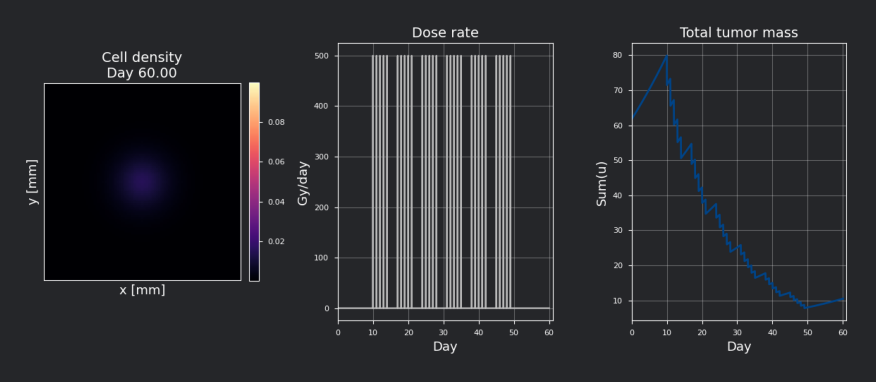

In [10]:
# Podgląd ostatniej klatki (opcjonalnie)

if len(list(FRAMES_DIR.glob('frame_*.png'))) > 0:
    last = sorted(FRAMES_DIR.glob('frame_*.png'))[-1]
    import matplotlib.image as mpimg
    img = mpimg.imread(str(last))
    plt.figure(figsize=(6, 3))
    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Brak zapisanych klatek do podglądu.')